# I. Project Team Members

| Prepared by | Email | Prepared for |
| :-: | :-: | :-: |
| **Hardefa Rogonondo** | hardefarogonondo@gmail.com | **IMDb Sentiment Analysis Engine** |

# II. Notebook Target Definition

In this modeling and evaluation notebook of IMDb Sentiment Analysis Engine Project, we begin by initializing the random seed to ensure reproducibility of results. This is followed by token preprocessing, which prepares the data for deep learning training. We then move onto the baseline model training, carefully evaluating its performance to establish a standard. Subsequent steps include hyperparameter tuning to optimize the model's accuracy and efficiency. Finally, we review the performance of the tuned model and export it for production, marking the end of the notebook's journey from data preparation to a deployable sentiment classification model.

# III. Notebook Setup

## III.A. Import Libraries

In [1]:
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout, Embedding, LSTM
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from kerastuner import HyperModel
from kerastuner.tuners import Hyperband
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import random
import tensorflow as tf

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

C:\Users\harde\AppData\Local\Temp\ipykernel_2920\3154762682.py:6: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel


## III.B. Import Data

In [2]:
X_train = pd.read_pickle('../../data/processed/X_train.pkl')
X_test = pd.read_pickle('../../data/processed/X_test.pkl')
y_train = pd.read_pickle('../../data/processed/y_train.pkl')
y_test = pd.read_pickle('../../data/processed/y_test.pkl')

In [3]:
X_train.head()

,review
670,When i watch this movie i too get excited when...
36224,I just finished watching this (last weekend) a...
39381,Poor second-string feature from Universal Pict...
4397,"When I was younger, this movie always aired on..."
48699,"Don't get me wrong , I want to see marijuana l..."


In [4]:
X_test.head()

,review
21560,A hilarious Action comedy in which Damian Szif...
4334,"This movie has it all. Sight gags, subtle joke..."
42642,This movie is simply awesome. It is so hilario...
31502,Rosario Dawson stars as a girl who is date rap...
49051,PAGE 3 **** out of 4 StarsMadhvi (Konkona Sen)...


In [5]:
y_train.head()

670      1
36224    1
39381    0
4397     1
48699    0
Name: sentiment, dtype: int64

In [6]:
y_test.head()

21560    1
4334     1
42642    1
31502    0
49051    1
Name: sentiment, dtype: int64

# IV. Models Training and Evaluation

## IV.A. Data Shape Inspection

In [7]:
X_train.shape, X_test.shape

((39665, 1), (9917, 1))

In [8]:
y_train.shape, y_test.shape

((39665,), (9917,))

## IV.B. Data Information Inspection

In [9]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39665 entries, 670 to 12021
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  39665 non-null  object
dtypes: object(1)
memory usage: 619.8+ KB


In [10]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9917 entries, 21560 to 13348
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  9917 non-null   object
dtypes: object(1)
memory usage: 155.0+ KB


In [11]:
y_train.info()

<class 'pandas.core.series.Series'>
Index: 39665 entries, 670 to 12021
Series name: sentiment
Non-Null Count  Dtype
--------------  -----
39665 non-null  int64
dtypes: int64(1)
memory usage: 619.8 KB


In [12]:
y_test.info()

<class 'pandas.core.series.Series'>
Index: 9917 entries, 21560 to 13348
Series name: sentiment
Non-Null Count  Dtype
--------------  -----
9917 non-null   int64
dtypes: int64(1)
memory usage: 155.0 KB


## IV.C. Random Seed Initialization

In [13]:
def set_seed(seed=777):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [14]:
set_seed(777)

## IV.D. Tokens Preprocessing

In [15]:
max_vocab_size = 30000
max_length = 300
tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(X_train["review"])
X_train_seq = tokenizer.texts_to_sequences(X_train["review"])
X_test_seq = tokenizer.texts_to_sequences(X_test["review"])
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

In [16]:
model = Sequential([
    Embedding(max_vocab_size, 128, input_length=max_length),
    LSTM(64, return_sequences=False),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

## IV.E. Baseline Model Training

In [17]:
history = model.fit(X_train_pad, y_train, epochs=10, validation_data=(X_test_pad, y_test), callbacks=[early_stopping])

Epoch 1/10


1240/1240 [==============================] - 90s 71ms/step - loss: 0.6646 - accuracy: 0.5604 - val_loss: 0.6455 - val_accuracy: 0.5903
Epoch 2/10
1240/1240 [==============================] - 89s 72ms/step - loss: 0.5753 - accuracy: 0.6878 - val_loss: 0.6414 - val_accuracy: 0.5725
Epoch 3/10
1240/1240 [==============================] - 88s 71ms/step - loss: 0.5008 - accuracy: 0.7566 - val_loss: 0.4838 - val_accuracy: 0.8091
Epoch 4/10
1240/1240 [==============================] - 88s 71ms/step - loss: 0.5284 - accuracy: 0.7107 - val_loss: 0.3553 - val_accuracy: 0.8597
Epoch 5/10
1240/1240 [==============================] - 88s 71ms/step - loss: 0.2392 - accuracy: 0.9064 - val_loss: 0.2820 - val_accuracy: 0.8868
Epoch 6/10
1240/1240 [==============================] - 87s 70ms/step - loss: 0.1317 - accuracy: 0.9544 - val_loss: 0.2953 - val_accuracy: 0.8925
Epoch 7/10
1240/1240 [==============================] - 86s 69ms/step - loss: 0.0722 - accuracy: 0.9796 - val_loss: 0.3352

## IV.F. Baseline Model Performance Review

In [18]:
def get_metrics_dataframe(model, X_train, y_train, X_test, y_test):
    train_prediction = (model.predict(X_train) > 0.5).astype("int32")
    test_prediction = (model.predict(X_test) > 0.5).astype("int32")
    train_probs = model.predict(X_train)
    test_probs = model.predict(X_test)

    def get_prediction_metrics(y_true, y_pred, y_probs):
        report = classification_report(y_true, y_pred, output_dict=True)
        accuracy = accuracy_score(y_true, y_pred)
        auc_roc = roc_auc_score(y_true, y_probs)
        gini = 2 * auc_roc - 1
        metrics = {
            "precision": report["weighted avg"]["precision"],
            "recall": report["weighted avg"]["recall"],
            "f1-score": report["weighted avg"]["f1-score"],
            "accuracy": accuracy,
            "auc_roc": auc_roc,
            "gini": gini
        }
        return metrics
    train_metrics = get_prediction_metrics(
        y_train, train_prediction, train_probs)
    train_metrics["dataset"] = "Train"
    test_metrics = get_prediction_metrics(y_test, test_prediction, test_probs)
    test_metrics["dataset"] = "Test"
    return pd.DataFrame([train_metrics, test_metrics])


def display_confusion_matrix(model, X_train, y_train, X_test, y_test):
    train_prediction = (model.predict(X_train) > 0.5).astype("int32")
    test_prediction = (model.predict(X_test) > 0.5).astype("int32")
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ConfusionMatrixDisplay.from_predictions(
        y_train, train_prediction, ax=ax[0])
    ax[0].set_title("Train Confusion Matrix")
    ConfusionMatrixDisplay.from_predictions(y_test, test_prediction, ax=ax[1])
    ax[1].set_title("Test Confusion Matrix")
    plt.show()


def plot_train_vs_test_error(model, X_train, y_train, X_test, y_test):
    y_pred_train = (model.predict(X_train) > 0.5).astype("int32")
    y_pred_test = (model.predict(X_test) > 0.5).astype("int32")
    train_error = 1 - accuracy_score(y_train, y_pred_train)
    test_error = 1 - accuracy_score(y_test, y_pred_test)
    bars = plt.bar(["Train Error", "Test Error"], [train_error, test_error])
    plt.ylabel("Error Rate")
    plt.title("Train vs Test Error")
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.0005,
                 round(yval, 2), ha='center', va='bottom')
    plt.show()


def plot_roc_curve(model, X_train, y_train, X_test, y_test):
    y_pred_train_prob = model.predict(X_train)
    y_pred_test_prob = model.predict(X_test)
    fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_train_prob)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_test_prob)
    plt.figure(figsize=(12, 6))
    plt.plot(fpr_train, tpr_train,
             label=f"Train AUC: {roc_auc_score(y_train, y_pred_train_prob):.2f}")
    plt.plot(fpr_test, tpr_test,
             label=f"Test AUC: {roc_auc_score(y_test, y_pred_test_prob):.2f}")
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc='best')
    plt.show()

In [19]:
metrics_df = get_metrics_dataframe(model, X_train_pad, y_train, X_test_pad, y_test)
metrics_df

310/310 [==============================] - 7s 23ms/step


,precision,recall,f1-score,accuracy,auc_roc,gini,dataset
0,0.994859,0.994857,0.994857,0.994857,0.997815,0.995629,Train
1,0.889216,0.889180,0.889180,0.889180,0.953415,0.906829,Test


310/310 [==============================] - 8s 24ms/step


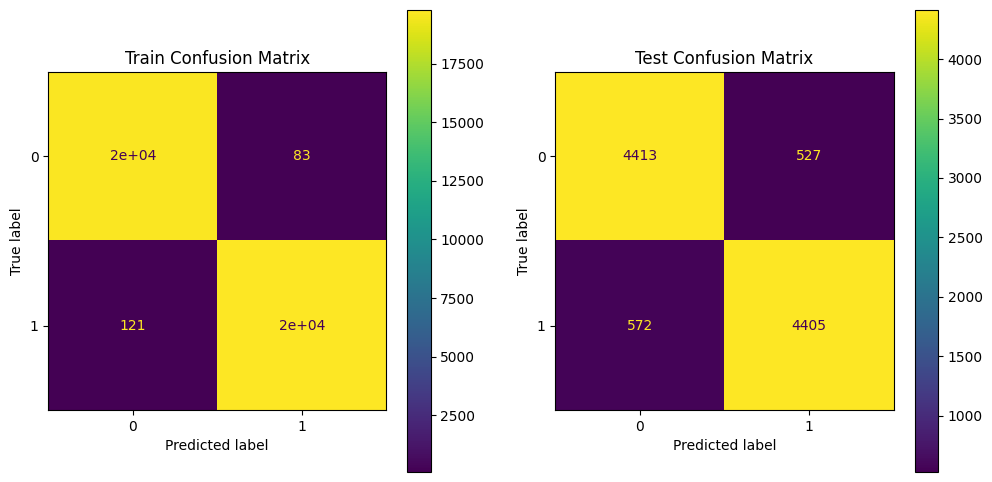

In [20]:
display_confusion_matrix(model, X_train_pad, y_train, X_test_pad, y_test)

310/310 [==============================] - 6s 21ms/step


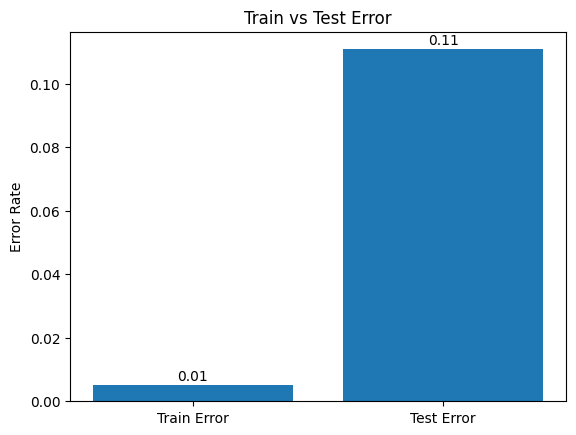

In [21]:
plot_train_vs_test_error(model, X_train_pad, y_train, X_test_pad, y_test)

310/310 [==============================] - 7s 23ms/step


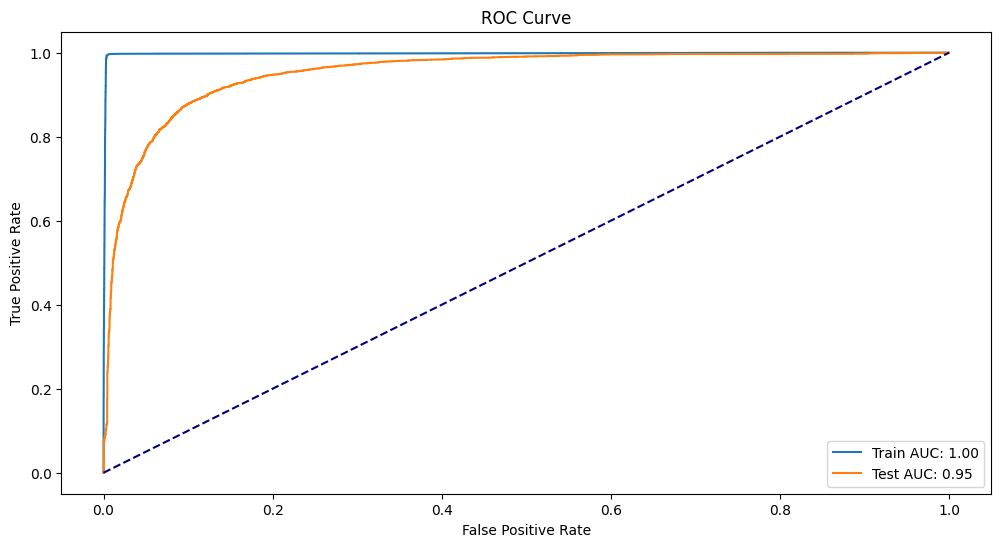

In [22]:
plot_roc_curve(model, X_train_pad, y_train, X_test_pad, y_test)

## IV.G. Hyperparameters Tuning

In [23]:
class LSTMHyperModel(HyperModel):
    def __init__(self, max_vocab_size, max_length):
        self.max_vocab_size = max_vocab_size
        self.max_length = max_length

    def build(self, hp):
        model = Sequential()
        model.add(Embedding(self.max_vocab_size,
                            hp.Int('embedding_dim', 64, 128, step=64),
                            input_length=self.max_length))
        model.add(LSTM(hp.Int('lstm_units', 64, 128, step=64)))
        model.add(Dropout(hp.Float('dropout_rate', 0.2, 0.4, step=0.2)))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer=hp.Choice('optimizer', ['adam']),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
        return model

In [24]:
hypermodel = LSTMHyperModel(max_vocab_size=max_vocab_size, max_length=max_length)
tuner = Hyperband(
    hypermodel,
    objective='val_accuracy',
    max_epochs=10,
    factor=5,
    directory='../../models/logs',
    project_name='hyperband_tuning'
)

In [25]:
tuner.search(X_train_pad, y_train, epochs=10, 
             validation_data=(X_test_pad, y_test), 
             callbacks=[early_stopping])

Trial 10 Complete [00h 07m 16s]
val_accuracy: 0.8896843791007996

Best val_accuracy So Far: 0.8896843791007996
Total elapsed time: 00h 44m 14s


In [26]:
best_model = tuner.get_best_models(num_models=1)[0]

## IV.H. Hypertuned Model Performance Review

In [27]:
best_metrics_df = get_metrics_dataframe(best_model, X_train_pad, y_train, X_test_pad, y_test)
best_metrics_df

310/310 [==============================] - 7s 24ms/step


,precision,recall,f1-score,accuracy,auc_roc,gini,dataset
0,0.976192,0.975949,0.975944,0.975949,0.993357,0.986715,Train
1,0.890477,0.889684,0.889618,0.889684,0.949340,0.898681,Test


310/310 [==============================] - 7s 24ms/step


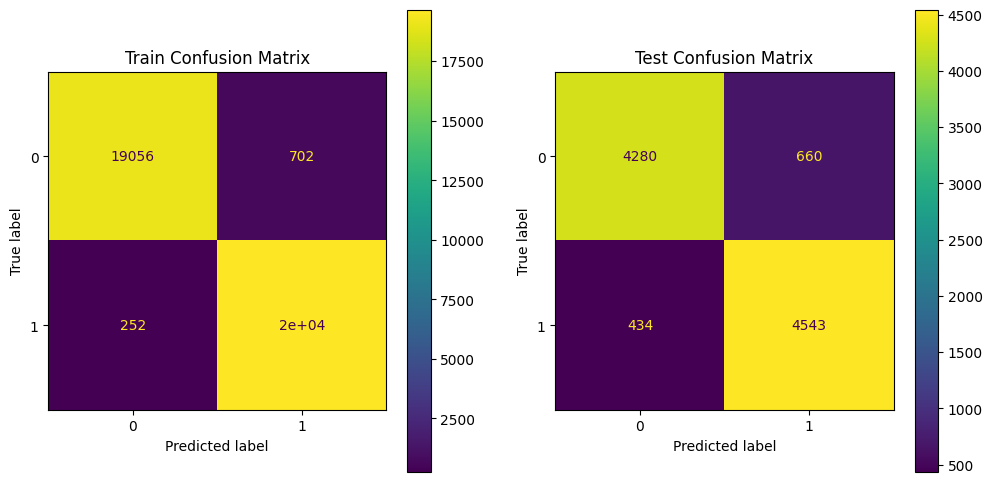

In [28]:
display_confusion_matrix(best_model, X_train_pad, y_train, X_test_pad, y_test)

310/310 [==============================] - 7s 24ms/step


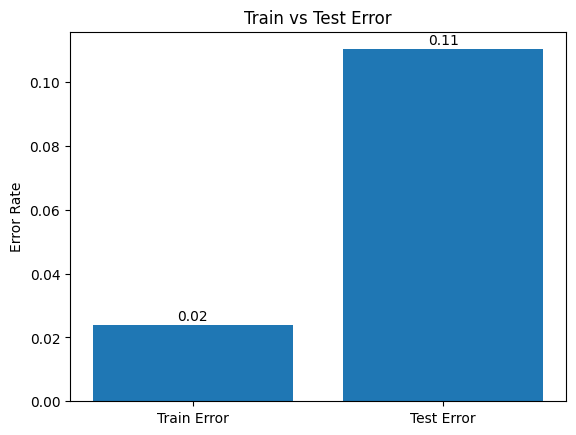

In [29]:
plot_train_vs_test_error(best_model, X_train_pad, y_train, X_test_pad, y_test)

310/310 [==============================] - 7s 23ms/step


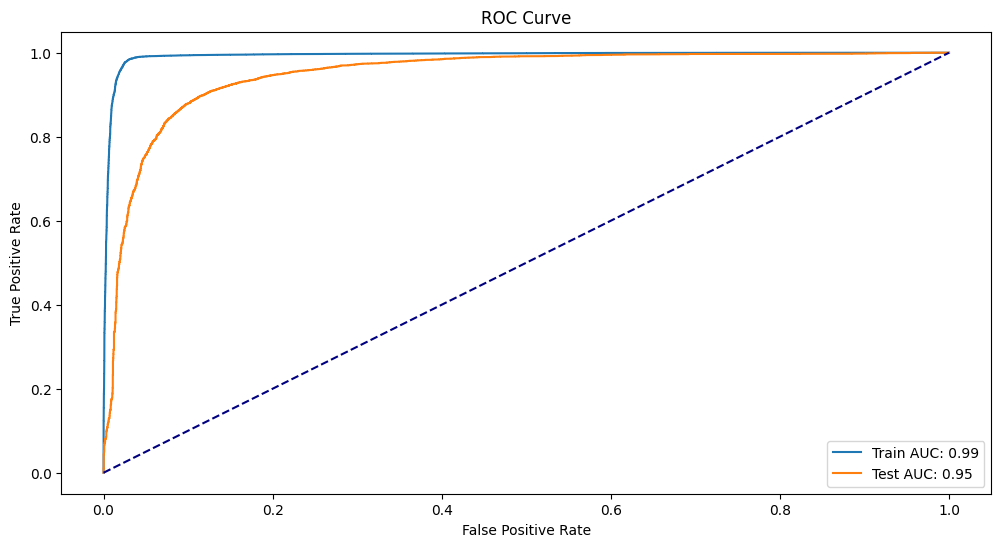

In [30]:
plot_roc_curve(best_model, X_train_pad, y_train, X_test_pad, y_test)

## IV.I. Model Simulation

In [31]:
new_reviews = ["This movie was excellent! The performances were oscar-worthy!",
               "I did not like this movie, it was too long and boring."]

In [32]:
new_reviews_seq = tokenizer.texts_to_sequences(new_reviews)
new_reviews_pad = pad_sequences(new_reviews_seq, maxlen=max_length, padding='post')

In [33]:
predictions = best_model.predict(new_reviews_pad)
predicted_classes = [1 if prob > 0.5 else 0 for prob in predictions]
for review, prediction in zip(new_reviews, predicted_classes):
    print(f"Review: {review}")
    print(f"Predicted Sentiment: {'Positive' if prediction == 1 else 'Negative'}\n")

1/1 [==============================] - 0s 34ms/step
Review: This movie was excellent! The performances were oscar-worthy!
Predicted Sentiment: Positive

Review: I did not like this movie, it was too long and boring.
Predicted Sentiment: Negative



## IV.J. Export Model

In [35]:
with open('../../models/tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

best_model.save('../../models/sentiment_model')

INFO:tensorflow:Assets written to: ../../models/sentiment_model\assets


INFO:tensorflow:Assets written to: ../../models/sentiment_model\assets
